2025-03-15 13:28:05.620895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742025485.666324   41772 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742025485.678973   41772 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742025485.773314   41772 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742025485.773337   41772 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742025485.773339   41772 computation_placer.cc:177] computation placer alr

Reloading Tuner from tcn_tuner_results/cnn_tcn_optimization/tuner0.json
Epoch 1/50


W0000 00:00:1742025501.952999   41772 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


253/253 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 13.3045 - rmse: 1.9764 - val_loss: 2.4260 - val_rmse: 0.7546
Epoch 2/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 4.7953 - rmse: 1.0770 - val_loss: 1.8695 - val_rmse: 0.6695
Epoch 3/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 2.5432 - rmse: 0.8473 - val_loss: 1.0421 - val_rmse: 0.6366
Epoch 4/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 1.1737 - rmse: 0.6837 - val_loss: 0.7250 - val_rmse: 0.7102
Epoch 5/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.4759 - rmse: 0.5496 - val_loss: 0.6625 - val_rmse: 0.7485
Epoch 6/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.2968 - rmse: 0.4971 - val_loss: 0.3573 - val_rmse: 0.5467
Epoch 7/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.2455 - rmse: 0.4604 - val_loss: 0.2690 - val_rmse: 0.4663
Epoch 8/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.2357 - rmse: 0.4507 - val_loss: 0.2381 - val_rmse: 0.4353
Epoch 9/50
253/253 ━━━━━━━━━━━━━━━

Best Model Test Loss: 0.3303, Test RMSE: 0.5291


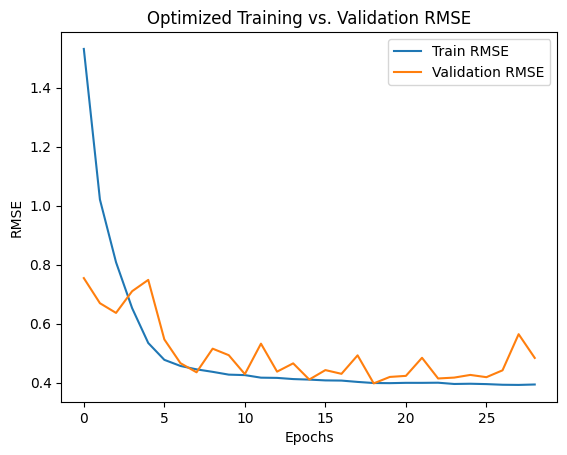

In [1]:
import keras_tuner as kt
from keras.models import Model
from keras import layers, optimizers, regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
import json

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Feature and target columns
x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
lookback = 128  

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)


# Define Model for Hyperparameter Tuning
def build_model(hp):
    x_shape = (lookback, len(x_cols))  # Define input shape
    
    regs = {
        'kernel_regularizer': regularizers.l2(hp.Float('reg_rate', 1e-6, 1e-3, sampling='log')),
        'bias_regularizer': regularizers.l2(hp.Float('reg_rate', 1e-6, 1e-3, sampling='log')),
        'activity_regularizer': regularizers.l2(hp.Float('reg_rate', 1e-6, 1e-3, sampling='log'))
    }

    def add_common_layers(z):
        z = layers.BatchNormalization()(z)
        activation_choice = hp.Choice('activation', ['relu', 'tanh', 'selu'])
        z = layers.Activation(activation_choice)(z)  # Apply activation properly
        dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
        z = layers.Dropout(dropout_rate)(z)  # Apply dropout properly
        return z


    x = layers.Input(shape=x_shape)
    y = x  

    for i in range(hp.Int('n_layers', 2, 5)):  # Search for best number of layers (2 to 5)
        dilation_rate = hp.Int('dilation_start_rate', 1, 4) * (2 ** i)

        if i % 2 == 0 and hp.Boolean('residual'):
            shortcut = y  

        y = layers.Conv1D(
            hp.Int('n_units', 32, 128, step=32), 
            hp.Int('kernel_size', 2, 5),  
            padding='causal',
            dilation_rate=dilation_rate,
            activation=None,  
            **regs
        )(y)
        y = add_common_layers(y)

        if i % 2 == 1 and hp.Boolean('residual'):
            shortcut = layers.Conv1D(hp.Int('n_units', 32, 128, step=32), kernel_size=1, padding='causal', activation=None, **regs)(shortcut)
            y = layers.add([shortcut, y])

    y = layers.GlobalMaxPooling1D()(y)
    y = layers.Dense(len(y_cols))(y)  

    model = Model(inputs=x, outputs=y)

    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    lr_rate = hp.Float('lr_rate', 1e-5, 1e-2, sampling='log')

    opt = optimizers.Adam(learning_rate=lr_rate) if optimizer == 'adam' else (
          optimizers.RMSprop(learning_rate=lr_rate) if optimizer == 'rmsprop' else 
          optimizers.SGD(learning_rate=lr_rate))

    model.compile(optimizer=opt, loss='mse', metrics=[rmse])
    return model

# Define Tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective("val_rmse", direction="min"),
    max_trials=15,  # Number of different hyperparameter sets to try
    executions_per_trial=1,  # Number of times to train each model configuration
    directory='tcn_tuner_results',
    project_name='cnn_tcn_optimization'
)

# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_rmse', patience=5, mode='min')])

# Get Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train Best Model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_rmse', patience=10, mode='min')])

# Evaluate on Test Set
test_loss, test_rmse = best_model.evaluate(X_test, y_test)
print(f'Best Model Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}')

# Save Model
best_model.save('optimized_cnn_tcn_model.h5')

# Save Best Hyperparameters
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open("best_hyperparameters.json", "w") as f:
    json.dump(best_hps_dict, f, indent=4)

# Plot RMSE over Epochs
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Optimized Training vs. Validation RMSE')
plt.show()
